In [1]:
from functools import partial
import jax
import os
import html
import numpy as np

from datetime import datetime
from jax import numpy as jp
jax.config.update("jax_debug_nans", False)
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output, display
from brax.io import html

import shutil

from src.pods.Pods import train as train_pods
from src.hds.Hds import train as train_hds
from src.envs.original import Pendulum 
from src.envs.realistic import RealisticPendulum 
from src.dyn_model.Predict import pretrained_params




In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
print(jax.devices())

gpu
[cuda(id=0)]


In [3]:
env = Pendulum.Pendulum()
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

#HTML(html.render(env.sys, [state.pipeline_state]))

In [4]:
ckpt_dir = './tmp/flax_ckpt'

if os.path.exists(ckpt_dir):
    shutil.rmtree(ckpt_dir)  # Remove any existing checkpoints from the last notebook run.

In [5]:

def progress_f(x_data,y_data,epoch,reward):
    print(reward)
    x_data.append(epoch)
    y_data.append(reward)
    clear_output(wait=True)
    plt.xlabel('Epoch')
    plt.ylabel('Total Reward')
    plt.plot(x_data, y_data)
    plt.show()

# policy_hds = train_hds(env,trajectory_length=100 ,num_samples=100,epochs=20, inner_epochs=20, alpha_a=8e-5, aggregation_factor_beta=0.175,
#                        init_learning_rate=1e-3, init_noise=0.1, noise_decay=0.5, progress_fn=progress_f) 

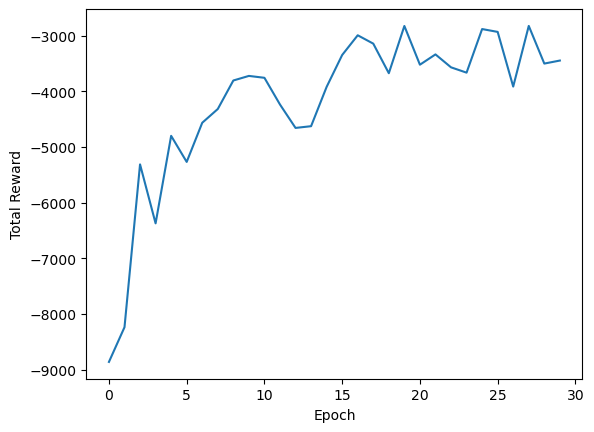

big epoch: 29 small epoch: 0 Loss 0.00048421593447326073
big epoch: 29 small epoch: 1 Loss 0.00013606543888561594
big epoch: 29 small epoch: 2 Loss 0.0002940920398725118
big epoch: 29 small epoch: 3 Loss 8.225404720646343e-05
big epoch: 29 small epoch: 4 Loss 0.00013445919473642192
big epoch: 29 small epoch: 5 Loss 0.00012112976845667583
big epoch: 29 small epoch: 6 Loss 0.00016389563934482724
big epoch: 29 small epoch: 7 Loss 0.00020680255529282584
big epoch: 29 small epoch: 8 Loss 0.000165862180561584
big epoch: 29 small epoch: 9 Loss 0.00013538799507978964
big epoch: 29 small epoch: 10 Loss 0.00010892322280012281
big epoch: 29 small epoch: 11 Loss 9.444670397787573e-05
big epoch: 29 small epoch: 12 Loss 9.160487172533589e-05
big epoch: 29 small epoch: 13 Loss 9.261859848173762e-05
big epoch: 29 small epoch: 14 Loss 9.481762694912205e-05
big epoch: 29 small epoch: 15 Loss 8.862620269834681e-05
big epoch: 29 small epoch: 16 Loss 7.74715380777646e-05
big epoch: 29 small epoch: 17 Loss 

In [6]:
policy_pods = train_pods(env,trajectory_length=100 ,num_samples=50,epochs=30, inner_epochs=20, alpha_a=2e-5, init_learning_rate=1e-3, progress_fn=progress_f)


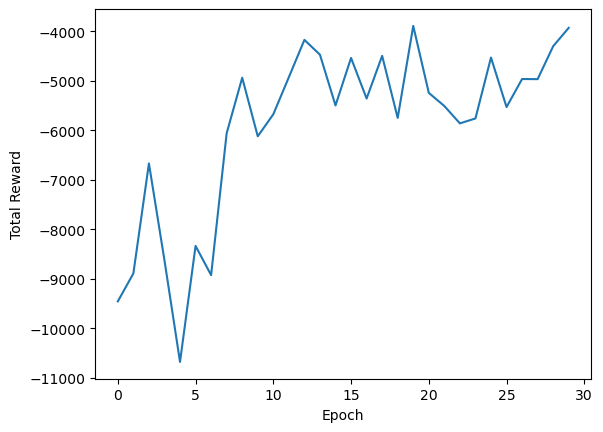

big epoch: 29 small epoch: 0 Loss 1.5583918716128987e-05
big epoch: 29 small epoch: 1 Loss 1.2830092315635695e-05
big epoch: 29 small epoch: 2 Loss 1.796106334873726e-05
big epoch: 29 small epoch: 3 Loss 1.8687046375662515e-05
big epoch: 29 small epoch: 4 Loss 2.1255051133437364e-05
big epoch: 29 small epoch: 5 Loss 2.3541392129181214e-05
big epoch: 29 small epoch: 6 Loss 2.4184186258317852e-05
big epoch: 29 small epoch: 7 Loss 2.7654038987718205e-05
big epoch: 29 small epoch: 8 Loss 2.7656728249402365e-05
big epoch: 29 small epoch: 9 Loss 2.669772921894164e-05
big epoch: 29 small epoch: 10 Loss 3.0329061871025387e-05
big epoch: 29 small epoch: 11 Loss 2.716659022031214e-05
big epoch: 29 small epoch: 12 Loss 3.100053446072414e-05
big epoch: 29 small epoch: 13 Loss 2.8224953772609485e-05
big epoch: 29 small epoch: 14 Loss 3.081138950432371e-05
big epoch: 29 small epoch: 15 Loss 2.8234305991433937e-05
big epoch: 29 small epoch: 16 Loss 3.0332898035089783e-05
big epoch: 29 small epoch: 17

In [7]:
policy_hds = train_hds(env,trajectory_length=100 ,num_samples=50,epochs=30, inner_epochs=20, alpha_a=2e-5, aggregation_factor_beta=0.2, init_learning_rate=1e-3, init_noise=0.0, noise_decay=0.5, progress_fn=progress_f) 

In [12]:
realistic_env = RealisticPendulum.RealisticPendulum()
# inference_fn_hds = policy_hds()
inference_fn_pods = policy_pods()
inference_fn_hds = policy_hds()

@partial(jax.vmap, in_axes=(None, None, None, 0), axis_name="batch")
def rollout_policy(
        env, inference_fn, trajectory_length: int, prng_keys
    ):

    def step_trajectory(state_carry, rng_key):
        action = inference_fn(state_carry.obs)
        next_state = env.step(state_carry, action)
        return next_state, (state_carry.obs, action, next_state.reward)

    state = env.reset(prng_keys)
    keys = jax.random.split(prng_keys, trajectory_length)
    _, (states, actions, rewards_future) = jax.lax.scan(
        step_trajectory, state, xs=keys
    )

    states = jax.numpy.reshape(
        states, (trajectory_length, env.observation_size)
    )
    actions = jax.numpy.reshape(
        actions, (trajectory_length, env.action_size)
    )

    totalreward = jp.sum(rewards_future)

    return states, actions, totalreward

prng_key = jax.random.PRNGKey(seed=0)
subkeys = jax.random.split(prng_key, num=50)

_, _ , rewards_original_pods  = rollout_policy(env, inference_fn_pods, 100, subkeys)
_, _ , rewards_realistic_pods = rollout_policy(realistic_env, inference_fn_pods, 100, subkeys)
# _, _ , rewards_hds = rollout_policy(realistic_env, inference_fn_hds, 100, subkeys)
# _, _ , rewards_hds_train_env = rollout_policy(env, inference_fn_hds, 100, subkeys)

_, _ , rewards_original_hds  = rollout_policy(env, inference_fn_hds, 100, subkeys)
_, _ , rewards_realistic_hds = rollout_policy(realistic_env, inference_fn_hds, 100, subkeys)

average_reward_original_pods = jp.mean(rewards_original_pods)
average_reward_realistic = jp.mean(rewards_realistic_pods)
average_reward_original_hds = jp.mean(rewards_original_hds)
average_reward_realistic_hds = jp.mean(rewards_realistic_hds)

# average_reward_hds = jp.mean(rewards_hds)
# average_reward_hds_train_env = jp.mean(rewards_hds_train_env)

In [13]:
print(f'PODS on real environment {jp.mean(jp.array(average_reward_realistic))}')
print(f'PODS on train environment {jp.mean(jp.array(average_reward_original_pods))}')
print(f'HDS on real environment {jp.mean(jp.array(average_reward_realistic_hds))}')
print(f'HDS on train environment {jp.mean(jp.array(average_reward_original_hds))}')
# print(f'HDS on real environment {jp.mean(jp.array(average_reward_hds))}')
# print(f'HDS on train environment {jp.mean(jp.array(average_reward_hds_train_env))}')

PODS on real environment -7399.713352728966
PODS on train environment -4183.555355464658
HDS on real environment -6198.186009534614
HDS on train environment -2928.749659473951


In [10]:
# seeds = [x for x in range(100)]
# plt.figure(figsize=(10, 6))
# plt.plot(seeds, rewards_realistic, label='PODS on Real Environment', color='blue')
# plt.plot(seeds, rewards_original_pods, label='PODS on Train Environment', color='red')
# plt.plot(seeds, rewards_hds, label='HDS on Real Environment (Ours)', color='green')
# plt.plot(seeds, rewards_hds_train_env, label='HDS on Train Environment (Ours)', color='orange')
# plt.xlabel('Seed')
# plt.ylabel('Total Reward')
# plt.title('Total Reward across Seeds')
# plt.legend()
# plt.grid(True)
# plt.show()

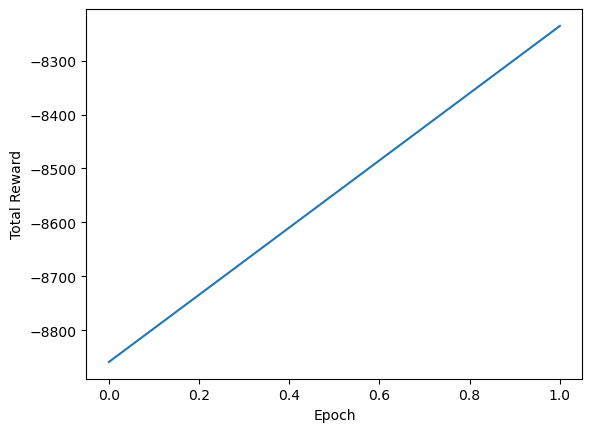

big epoch: 1 small epoch: 0 Loss 0.001185930483003983
big epoch: 1 small epoch: 1 Loss 0.00015922548960978122
big epoch: 1 small epoch: 2 Loss 0.00026710645782489396
big epoch: 1 small epoch: 3 Loss 0.00029661923801940575
big epoch: 1 small epoch: 4 Loss 0.0002702083103797587
big epoch: 1 small epoch: 5 Loss 0.000321013527852235
big epoch: 1 small epoch: 6 Loss 0.00033498649224486353
big epoch: 1 small epoch: 7 Loss 0.000337503298699707
big epoch: 1 small epoch: 8 Loss 0.00047088632139230676
big epoch: 1 small epoch: 9 Loss 0.0003065508790136474
big epoch: 1 small epoch: 10 Loss 0.0003697317425877364
big epoch: 1 small epoch: 11 Loss 0.0004254440356172346
big epoch: 1 small epoch: 12 Loss 0.000376522051078835
big epoch: 1 small epoch: 13 Loss 0.0004378451358422797
big epoch: 1 small epoch: 14 Loss 0.00041981807121847667
big epoch: 1 small epoch: 15 Loss 0.0004007168559869062
big epoch: 1 small epoch: 16 Loss 0.0004540224962372519
big epoch: 1 small epoch: 17 Loss 0.0004267213310520969


KeyboardInterrupt: 

In [11]:
def run_over_aggregation_factor(aggregation_factor_beta):
    policy = train_hds(env,trajectory_length=100 ,num_samples=50,epochs=20, inner_epochs=20, alpha_a=2e-5, aggregation_factor_beta=aggregation_factor_beta,
                       init_learning_rate=1e-3, init_noise=0.0, noise_decay=0.0, progress_fn=progress_f) 
    inference_fn = policy()
    
    prng_key = jax.random.PRNGKey(seed=0)
    subkeys = jax.random.split(prng_key, num=50)
    _, _ , rewards_hds_real_env  = rollout_policy(realistic_env, inference_fn, 100, subkeys)
    average_reward_hds_real_env = jp.mean(rewards_hds_real_env)
    print(aggregation_factor_beta)
    return average_reward_hds_real_env

aggregation_factors = np.linspace(0.0,0.3,5)

rewards_dep_aggregation_factor = [run_over_aggregation_factor(x) for x in aggregation_factors]
rewards_pods_real_env = [average_reward_realistic for _ in aggregation_factors]
rewards_pods_train_env = [average_reward_original_pods for _ in aggregation_factors]

plt.figure(figsize=(10, 6))
clear_output(wait=True)
plt.plot(aggregation_factors, rewards_dep_aggregation_factor, label='HDS on Real Environment (Ours)', color='green')
plt.plot(aggregation_factors, rewards_pods_real_env, label='PODS on Real Environment, Mean', color='red')
plt.plot(aggregation_factors, rewards_pods_train_env, label='PODS on Train Environment, Mean', color='blue')
plt.legend()
plt.xlabel('Aggregation Factor')
plt.ylabel('Total Reward')
plt.title('Total Reward across Aggregation Factors')
plt.grid(True)
plt.show()



#save plot 
plt.figure(figsize=(10, 6))
clear_output(wait=True)
plt.plot(aggregation_factors, rewards_dep_aggregation_factor, label='HDS on Real Environment (Ours)', color='green')
plt.plot(aggregation_factors, rewards_pods_real_env, label='PODS on Real Environment, Mean', color='red')
plt.plot(aggregation_factors, rewards_pods_train_env, label='PODS on Train Environment, Mean', color='blue')
plt.legend()
plt.xlabel('Aggregation Factor')
plt.ylabel('Total Reward')
plt.title('Total Reward across Aggregation Factors')
plt.grid(True)
plt.savefig('aggregation_factor.png')

In [ ]:

# yes=html.render(env.sys.replace(dt=env.dt), rollout_realistic)
# with open("data.html", "w") as file:
#     file.write(yes)